**FULLY REFACTORED VERSION** - A template of the RL training, with H-network trained along side the DDQN agent

This notebook uses the refactored environment factory pattern for creating discrete environments.
It uses the unified factory pattern for environments, H-network modules, and callbacks.

In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
from datetime import datetime
import sys

from utils import print_log

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# load the created dataset
dataset_folder_path = Path("dataset", "20250707_downsampled_1min", "split")

In [4]:
from utils_data_split import load_split_data_from_folder, convert_to_naive_datetimes, convert_to_naive_datetimes_df

In [5]:
aggregate_load_segments_train, aggregate_load_df_train = load_split_data_from_folder(dataset_folder_path, 'train')
aggregate_load_segments_test, aggregate_load_df_test = load_split_data_from_folder(dataset_folder_path, 'test') 
aggregate_load_segments_validation, aggregate_load_df_validation = load_split_data_from_folder(dataset_folder_path, 'val')

In [6]:
aggregate_load_segments_train, aggregate_load_df_train = convert_to_naive_datetimes(aggregate_load_segments_train), convert_to_naive_datetimes_df(aggregate_load_df_train)
aggregate_load_segments_test, aggregate_load_df_test = convert_to_naive_datetimes(aggregate_load_segments_test), convert_to_naive_datetimes_df(aggregate_load_df_test)
aggregate_load_segments_validation, aggregate_load_df_validation = convert_to_naive_datetimes(aggregate_load_segments_validation), convert_to_naive_datetimes_df(aggregate_load_df_validation)

In [7]:
aggregate_load_df_train

,datetime,aggregate,timestamp
0,2013-01-08 00:00:05,234.000000,1357603205
1,2013-01-08 00:01:05,230.407069,1357603265
2,2013-01-08 00:02:05,230.680121,1357603325
3,2013-01-08 00:03:05,231.607379,1357603385
4,2013-01-08 00:04:05,231.280688,1357603445
...,...,...,...
231546,2013-12-30 23:55:01,176.973052,1388447701
231547,2013-12-30 23:56:01,177.850890,1388447761
231548,2013-12-30 23:57:01,177.333811,1388447821
231549,2013-12-30 23:58:01,178.462801,1388447881


In [8]:
aggregate_load_segments_train

[(datetime.datetime(2013, 1, 8, 0, 0),
  datetime.datetime(2013, 1, 8, 23, 59, 59, 999000)),
 (datetime.datetime(2013, 1, 9, 0, 0),
  datetime.datetime(2013, 1, 9, 23, 59, 59, 999000)),
 (datetime.datetime(2013, 1, 10, 0, 0),
  datetime.datetime(2013, 1, 10, 23, 59, 59, 999000)),
 (datetime.datetime(2013, 2, 27, 0, 0),
  datetime.datetime(2013, 2, 27, 23, 59, 59, 999000)),
 (datetime.datetime(2013, 2, 28, 0, 0),
  datetime.datetime(2013, 2, 28, 23, 59, 59, 999000)),
 (datetime.datetime(2013, 3, 8, 0, 0),
  datetime.datetime(2013, 3, 8, 23, 59, 59, 999000)),
 (datetime.datetime(2013, 3, 9, 0, 0),
  datetime.datetime(2013, 3, 9, 23, 59, 59, 999000)),
 (datetime.datetime(2013, 3, 10, 0, 0),
  datetime.datetime(2013, 3, 10, 23, 59, 59, 999000)),
 (datetime.datetime(2013, 3, 28, 0, 0),
  datetime.datetime(2013, 3, 28, 23, 59, 59, 999000)),
 (datetime.datetime(2013, 3, 29, 0, 0),
  datetime.datetime(2013, 3, 29, 23, 59, 59, 999000)),
 (datetime.datetime(2013, 3, 30, 0, 0),
  datetime.datetim

---

(DDQN) only

We have to quantize the data into per 0.05kW = 50W. This is for the charging action and other stuffs

In [9]:
# https://stackoverflow.com/questions/47949053/round-to-nearest-1000-in-pandas

def round_to_nearest_50(x):
    """Round to the nearest 50"""
    return ((x + 25) / 50).astype(int) * 50

aggregate_load_df_train["aggregate"] = round_to_nearest_50(aggregate_load_df_train["aggregate"])
aggregate_load_df_validation["aggregate"] = round_to_nearest_50(aggregate_load_df_validation["aggregate"])
aggregate_load_df_test["aggregate"] = round_to_nearest_50(aggregate_load_df_test["aggregate"])

# then cap at 5kW
aggregate_load_df_train["aggregate"] = aggregate_load_df_train["aggregate"].clip(upper=5000)
aggregate_load_df_validation["aggregate"] = aggregate_load_df_validation["aggregate"].clip(upper=5000)
aggregate_load_df_test["aggregate"] = aggregate_load_df_test["aggregate"].clip(upper=5000)

In [10]:
aggregate_load_df_train

,datetime,aggregate,timestamp
0,2013-01-08 00:00:05,250,1357603205
1,2013-01-08 00:01:05,250,1357603265
2,2013-01-08 00:02:05,250,1357603325
3,2013-01-08 00:03:05,250,1357603385
4,2013-01-08 00:04:05,250,1357603445
...,...,...,...
231546,2013-12-30 23:55:01,200,1388447701
231547,2013-12-30 23:56:01,200,1388447761
231548,2013-12-30 23:57:01,200,1388447821
231549,2013-12-30 23:58:01,200,1388447881


---

Experiment start

In [11]:
# initialize experiment folder to store related information/data for future analysis

rl_datetime = datetime.now()

experiment_folder = Path(
    "experiments", rl_datetime.strftime('%Y%m%d_%H%M%S')
)

if not experiment_folder.exists():
    experiment_folder.mkdir(parents=True)

Create data loader

In [12]:
sys.path.append(str(Path('rl_env')))
sys.path.append(str(Path('model', 'H_network')))

from rl_env.data_loader import SimpleSmartMeterDataLoader

sm_dl_train = SimpleSmartMeterDataLoader(
    aggregate_load_segments=aggregate_load_segments_train,
    aggregate_load_df=aggregate_load_df_train,
    registry_path=experiment_folder / "simple_episode_registry_train.json"
)

sm_dl_train.get_divided_segments_length()

[SimpleDataLoader] Generated 162 episodes (1 day each)


162

In [13]:
sm_dl_train.divided_segments[7]

array([datetime.datetime(2013, 3, 10, 0, 0),
       datetime.datetime(2013, 3, 10, 23, 59, 59, 999000)], dtype=object)

In [14]:
# sample segment

sm_dl_train.get_aggregate_load_segment(13)

,timestamp,aggregate,datetime,segment_index,episode_content_id,episode_length_days
11231,1363996805,350,2013-03-23 00:00:05,13,5af8f04ee4a2,1
11232,1363996865,300,2013-03-23 00:01:05,13,5af8f04ee4a2,1
11233,1363996925,300,2013-03-23 00:02:05,13,5af8f04ee4a2,1
11234,1363996985,300,2013-03-23 00:03:05,13,5af8f04ee4a2,1
11235,1363997045,300,2013-03-23 00:04:05,13,5af8f04ee4a2,1
...,...,...,...,...,...,...
12666,1364082905,150,2013-03-23 23:55:05,13,5af8f04ee4a2,1
12667,1364082965,150,2013-03-23 23:56:05,13,5af8f04ee4a2,1
12668,1364083025,150,2013-03-23 23:57:05,13,5af8f04ee4a2,1
12669,1364083085,150,2013-03-23 23:58:05,13,5af8f04ee4a2,1


In [15]:
# create dataloader for validation and test sets
sm_dl_validation = SimpleSmartMeterDataLoader(
    aggregate_load_segments=aggregate_load_segments_validation,
    aggregate_load_df=aggregate_load_df_validation,
    registry_path=experiment_folder / "simple_episode_registry_validation.json"
)

# sm_dl_test = SimpleSmartMeterDataLoader(
#     dataset_path=dataset_folder_path,
# )

[SimpleDataLoader] Generated 73 episodes (1 day each)


Create the environment

In [16]:
import torch
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [17]:
ACTION_TYPE = 'discrete'

In [18]:
from model.H_network.common.factories import create_h_network_module_with_defaults
from model.H_network.h_network_arch import HNetworkType

h_network_kwargs = {
    "h_network_type": HNetworkType.H_NETWORK,
    "optimizer_class": torch.optim.RMSprop,
    "optimizer_kwargs": {"lr": 0.001},
}

h_network_rl_module = create_h_network_module_with_defaults(
    action_type=ACTION_TYPE,
    **h_network_kwargs,
    device=DEVICE
)

In [19]:
REWARD_LAMBDA = 0.5  # lambda for the reward function

In [20]:
from rl_env.base.env_module import SmartMeterEnvFactory
from rl_env.training_mode import TrainingMode
from decimal import Decimal

env_train = SmartMeterEnvFactory.create(
    action_type=ACTION_TYPE,
    smart_meter_data_loader=sm_dl_train,
    h_network_rl_module=h_network_rl_module,
    mode=TrainingMode.TRAIN,
    reward_lambda=REWARD_LAMBDA,
    render_mode=None,

    aggregate_step_size=50,  # step size for the aggregate load
    battery_step_size=Decimal("0.05")
)

[2025-08-05 02:21:40:356] [SmartMeterDiscreteEnv Train] Using data loader: SimpleSmartMeterDataLoader
[2025-08-05 02:21:40:356] [SmartMeterDiscreteEnv Train] Curriculum enabled: False
[2025-08-05 02:21:40:362] [SmartMeterDiscreteEnv Train]] Render mode set to 'None'. Render server at 127.0.0.1:50007. render_connected: False. render_client_socket: None


In [23]:
env_train.reset(seed=42)

[2025-08-05 02:27:17:833] [SmartMeterWorldDiscrete Train] Resetting environment with episode 14. Episode info: {'length': 1440, 'datetime_range': (Timestamp('2013-03-24 00:00:01'), Timestamp('2013-03-24 23:59:01'))}


({'aggregate_logit': 3,
  'battery_soc': array([0.15], dtype=float32),
  'timestamp_features': array([-0.5 ,  0.5 , -0.25], dtype=float32)},
 {'episode_index': 14,
  'current_step': 0,
  'datetime': '2013-03-24T00:00:01',
  'battery_soc (%)': 0.15000000596046448,
  'battery_soc (kWh)': 1.2000000476837158,
  'user_load (W)': 150.0,
  'grid_load (W)': None,
  'action (kW)': None,
  'battery_action (kW)': None,
  'reward': None,
  'f_signal': None,
  'g_signal': None})

In [22]:
env_train.np_random_seed

313443791360469483957751265269244743362

In [22]:
env_train.np_random_seed

260136006789508186722109788948668571717

In [22]:
h_network_rl_module.set_h_network(
    h_network_rl_module.initialize_h_network(output_dim=env_train.observation_space["aggregate_logit"].n)  # output_dim is the number states in the aggregate load space
)
h_network_rl_module.initialize_h_network_training()

In [23]:
h_network_rl_module.h_network

HNetwork(
  (LSTM_1): LSTM(2, 44, batch_first=True, bidirectional=True)
  (ac1): Tanh()
  (LSTM_2): LSTM(88, 44, batch_first=True, bidirectional=True)
  (ac2): Tanh()
  (fc): Linear(in_features=88, out_features=101, bias=True)
)

In [24]:
import torchinfo

torchinfo.summary(h_network_rl_module.h_network, input_size=(1, 1, 2))

Layer (type:depth-idx)                   Output Shape              Param #
HNetwork                                 [1, 1, 101]               --
├─LSTM: 1-1                              [1, 1, 88]                16,896
├─Tanh: 1-2                              [1, 1, 88]                --
├─LSTM: 1-3                              [1, 1, 88]                47,168
├─Tanh: 1-4                              [1, 1, 88]                --
├─Linear: 1-5                            [1, 1, 101]               8,989
Total params: 73,053
Trainable params: 73,053
Non-trainable params: 0
Total mult-adds (M): 0.07
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.29
Estimated Total Size (MB): 0.29

In [26]:
obs, info = env_train.reset()
obs

[2025-08-04 17:33:35:027] [SmartMeterWorldDiscrete Train] Resetting environment with episode 110. Episode info: {'length': 1440, 'datetime_range': (Timestamp('2013-09-26 00:00:00'), Timestamp('2013-09-26 23:59:00'))}


{'aggregate_logit': 4,
 'battery_soc': array([0.15], dtype=float32),
 'timestamp_features': array([-0.5 ,  0.  ,  0.25], dtype=float32)}

In [27]:
info

{'episode_index': 110,
 'current_step': 0,
 'datetime': '2013-09-26T00:00:00',
 'battery_soc (%)': 0.15000000596046448,
 'battery_soc (kWh)': 1.2000000476837158,
 'user_load (W)': 200.0,
 'grid_load (W)': None,
 'action (kW)': None,
 'battery_action (kW)': None,
 'reward': None,
 'f_signal': None,
 'g_signal': None}

In [28]:
env_train.reset_render_window()

Also initiate a validation environment for time-to-time validation

In [29]:
# also initiate the validation environment

env_validation = SmartMeterEnvFactory.create(
    action_type=ACTION_TYPE,
    smart_meter_data_loader=sm_dl_validation,
    h_network_rl_module=h_network_rl_module,
    mode=TrainingMode.VALIDATE, 
    reward_lambda=REWARD_LAMBDA,
    render_mode=None,
    
    aggregate_step_size=50,  # step size for the aggregate load
    battery_step_size=Decimal("0.05")
)

[2025-08-04 17:33:35:087] [SmartMeterDiscreteEnv Validate] Using data loader: SimpleSmartMeterDataLoader
[2025-08-04 17:33:35:087] [SmartMeterDiscreteEnv Validate] Curriculum enabled: False
[2025-08-04 17:33:35:091] [SmartMeterDiscreteEnv Validate]] Render mode set to 'None'. Render server at 127.0.0.1:50007. render_connected: False. render_client_socket: None


In [30]:
obs, info = env_validation.reset()

obs

[2025-08-04 17:33:35:116] [SmartMeterWorldDiscrete Validate] Resetting environment with episode 3. Episode info: {'length': 1440, 'datetime_range': (Timestamp('2013-02-21 00:00:02'), Timestamp('2013-02-21 23:59:02'))}


{'aggregate_logit': 5,
 'battery_soc': array([0.15], dtype=float32),
 'timestamp_features': array([-0.5       ,  0.        , -0.33333334], dtype=float32)}

In [31]:
info

{'episode_index': 3,
 'current_step': 0,
 'datetime': '2013-02-21T00:00:02',
 'battery_soc (%)': 0.15000000596046448,
 'battery_soc (kWh)': 1.2000000476837158,
 'user_load (W)': 250.0,
 'grid_load (W)': None,
 'action (kW)': None,
 'battery_action (kW)': None,
 'reward': None,
 'f_signal': None,
 'g_signal': None}

In [32]:
# callbacks for training - using refactored callback system
from rl_env.env_callbacks import TrainHNetworkEveryNEpisodes, SaveCheckpointEveryNEpisodes, ValidateEveryNEpisodes, EnvLoggingCallback, UpdateGlobalTimestepCallback

2025-08-04 17:33:35.372852: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-04 17:33:35.381252: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754325215.390329 3897192 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754325215.392883 3897192 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754325215.400362 3897192 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [33]:
# define a custom logger

from stable_baselines3.common.logger import configure

# all logs (json files, tensorboard) will be saved in the specified foler
logger = configure(str(experiment_folder / "logs_tb"), ["stdout", "json", "tensorboard"])

Logging to experiments/20250804_173332/logs_tb


In [34]:
# initialize a DQN agent
from model.DDQN.ddqn import DoubleDQN

rl_datetime = datetime.now()

rl_lr = 0.00025
rl_buffer_size = 150000  # scaled to match with our episode length
rl_batch_size = 128     # keep the same as the paper
rl_gamma = 1  # keep the same as the paper
rl_train_freq = (120, "step")  # scaled to match with our episode length
rl_target_update_interval = 7500  # scaled to match with our episode length
policy_kwargs = {
    "optimizer_class": torch.optim.RMSprop,     # keep the same as the paper
}

rl_model = DoubleDQN(
    "MultiInputPolicy",
    env_train,
    learning_rate=rl_lr,      # keep the same as the paper
    buffer_size=rl_buffer_size,         # scaled to match with our episode length
    batch_size=rl_batch_size,             # keep the same as the paper
    gamma=rl_gamma,                    # keep the same as the paper
    train_freq=rl_train_freq,   # scaled to match with our episode length
    target_update_interval=rl_target_update_interval,    # scaled to match with our episode length
    policy_kwargs=policy_kwargs,
    verbose=2,

)

rl_model.set_logger(logger)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [35]:
rl_model.policy

MultiInputPolicy(
  (q_net): QNetwork(
    (features_extractor): CombinedExtractor(
      (extractors): ModuleDict(
        (aggregate_logit): Flatten(start_dim=1, end_dim=-1)
        (battery_soc): Flatten(start_dim=1, end_dim=-1)
        (timestamp_features): Flatten(start_dim=1, end_dim=-1)
      )
    )
    (q_net): Sequential(
      (0): Linear(in_features=105, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=161, bias=True)
    )
  )
  (q_net_target): QNetwork(
    (features_extractor): CombinedExtractor(
      (extractors): ModuleDict(
        (aggregate_logit): Flatten(start_dim=1, end_dim=-1)
        (battery_soc): Flatten(start_dim=1, end_dim=-1)
        (timestamp_features): Flatten(start_dim=1, end_dim=-1)
      )
    )
    (q_net): Sequential(
      (0): Linear(in_features=105, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_feature

In [36]:
env_train.save_environment_config(file_folder=experiment_folder)

[2025-08-04 17:33:36:502] [SmartMeterDiscreteEnv Train] Environment config saved to experiments/20250804_173332/env_config_train.json


In [46]:
# also save the experiment details for future reference
experiment_details = {
    "action_type": ACTION_TYPE,
    "agent_type": "DDQN",
    "h_network_parameters": {
        "h_network_type": h_network_rl_module.h_network_type.name,
        "optimizer_class": h_network_rl_module.optimizer_class.__name__,
        "optimizer_kwargs": h_network_rl_module.optimizer_kwargs
    },
    "reward_lambda": env_train.reward_lambda,
    "dataloader_type": sm_dl_train.__class__.__name__,
    "reward_lambda": REWARD_LAMBDA,
    "agent_paramters": {
        "learning_rate": rl_lr,
        "buffer_size": rl_buffer_size,
        "batch_size": rl_batch_size,
        "gamma": rl_gamma,
        "train_freq": rl_train_freq,
        "target_update_interval": rl_target_update_interval,
        "policy_kwargs": {
            "optimizer_class": policy_kwargs["optimizer_class"].__name__,
        }
    }
}

# save the experiment details
with open(experiment_folder / "experiment_details.json", 'w') as f:
    import json
    json.dump(experiment_details, f, indent=4)

In [38]:
# define some callbacks here

every_n_episodes = 5
sweep_every_n_episodes = 5 * 10  # every 50 episodes

env_logging_callback = EnvLoggingCallback(log_folder=experiment_folder / "logs_train")

eval_callback = ValidateEveryNEpisodes(
    every_n_episodes=every_n_episodes * 5,
    sweep_every_n_episodes=sweep_every_n_episodes,
    validation_log_folder=experiment_folder / "logs_validation",
    validation_env=env_validation,
    h_network_rl_module=h_network_rl_module,
    best_model_save_path=experiment_folder / "best_model"
)

[2025-08-04 17:33:36:565] Logging environment information to experiments/20250804_173332/logs_train


In [39]:


from rl_env.base.env_module import SmartMeterEnvironmentBase


rl_model.learn(
    total_timesteps=24 * 60 * 60,  # 600 episodes, each episode is 24 hours (with 1 min sample frequency)
    progress_bar=False,
    tb_log_name="DDQL_SmartMeterWorldDiscrete",
    callback=[
        UpdateGlobalTimestepCallback(),
        env_logging_callback,
        TrainHNetworkEveryNEpisodes(every_n_episodes=every_n_episodes, h_network_rl_module=h_network_rl_module),
        SaveCheckpointEveryNEpisodes(every_n_episodes=every_n_episodes, h_network_rl_module=h_network_rl_module, save_folder=experiment_folder / "checkpoints"),
        eval_callback
    ]
)

# save the training results
print_log("Saving training results...")

SmartMeterEnvironmentBase.save_episodes_rewards(env_logging_callback.get_episode_rewards(), experiment_folder / "logs_train", TrainingMode.TRAIN)

h_network_rl_module.save_train_loss_list(experiment_folder / "logs_train" / "h_network_train_loss_list.json")

# save both RL modeel and H-network at the end of training
rl_model_path = experiment_folder / f"rl_model.zip"
h_network_path = experiment_folder / f"h_network2.pth" if h_network_rl_module.h_network_type == HNetworkType.H_NETWORK2 else experiment_folder / f"h_network.pth"

rl_model.save(rl_model_path)
h_network_rl_module.save_h_network(h_network_path)

[2025-08-04 17:33:36:602] [SmartMeterWorldDiscrete Train] Resetting environment with episode 96. Episode info: {'length': 1440, 'datetime_range': (Timestamp('2013-08-28 00:00:02'), Timestamp('2013-08-28 23:59:02'))}
[2025-08-04 17:33:40:858] [SmartMeterDiscreteEnv Train] Episode finished. Sum of rewards: 31.44107025894158. Mean of rewards: 0.02184924965875023. Std of rewards: 0.0017096596332500304
[2025-08-04 17:33:40:858] [SmartMeterDiscreteEnv Train] Episode f_signal sum: -66.21445566788316. Mean: -0.04601421519658316. Std: 0.0021443619750988216
[2025-08-04 17:33:40:858] [SmartMeterDiscreteEnv Train] Episode g_signal sum: 3.3323151500000003. Mean: 0.0023157158790826967. Std: 0.0028479717654980577
[2025-08-04 17:33:40:862] [SmartMeterWorldDiscrete Train] Resetting environment with episode 8. Episode info: {'length': 1440, 'datetime_range': (Timestamp('2013-03-28 00:00:05'), Timestamp('2013-03-28 23:59:05'))}
[2025-08-04 17:33:40:879] [SmartMeterDiscreteEnv Train] Episode 0001 info sav

Read the logged .json file and open it as a Dataframe

In [41]:
from stable_baselines3.common.logger import read_json

# Read the logged .json file and open it as a Dataframe
log_file_path = experiment_folder / "logs_tb" / "progress.json"
if log_file_path.exists():
    log_data = read_json(log_file_path)

log_data

,rollout/exploration_rate,train/learning_rate,train/n_updates,train/loss,rollout_train/reward_sum,rollout_train/f_signal_sum,rollout_train/g_signal_sum,time/episodes,rollout/ep_rew_mean,rollout/ep_len_mean,time/fps,time/time_elapsed,time/total_timesteps,validation/reward_mean,validation/f_signal_mean,validation/g_signal_mean
0,0.367106,0.00025,47,0.004245,30.563082,-66.446007,5.319842,4,31.020700,1439.000000,318,18,5756,NaN,NaN,NaN
1,0.050000,0.00025,95,0.001704,44.912731,-91.271799,1.446338,8,36.172977,1439.000000,298,38,11512,NaN,NaN,NaN
2,0.050000,0.00025,143,0.000807,90.240621,-182.159812,1.678570,12,47.848536,1439.000000,292,59,17268,NaN,NaN,NaN
3,0.050000,0.00025,191,0.002198,180.307203,-361.830402,1.215996,16,68.214457,1439.000000,289,79,23024,NaN,NaN,NaN
4,0.050000,0.00025,239,0.000424,122.635801,-246.920805,1.649203,20,76.907213,1439.000000,288,99,28780,NaN,NaN,NaN
5,0.050000,0.00025,287,0.000481,133.478958,-268.571343,1.613428,24,87.957696,1439.000000,287,120,34536,NaN,NaN,NaN
6,0.050000,0.00025,335,0.000595,141.811351,-284.701201,1.078500,28,95.107434,1439.000000,209,192,40292,150.383043,-302.370484,1.604397
7,0.050000,0.00025,383,0.000894,118.787795,-238.879596,1.304006,32,101.047959,1439.000000,215,213,46048,NaN,NaN,NaN
8,0.050000,0.00025,431,0.000866,158.843273,-318.947194,1.260648,36,106.390606,1439.000000,220,235,51804,NaN,NaN,NaN
9,0.050000,0.00025,479,0.000618,158.082436,-318.996344,2.831471,40,110.070417,1439.000000,225,255,57560,NaN,NaN,NaN


End of Training

---

(optional) reload a trained H-network & agent

In [12]:
# initialize experiment folder to store related information/data for future analysis

rl_datetime = datetime(2025, 7, 30, 17, 54, 8)

experiment_folder = Path(
    "experiments", rl_datetime.strftime('%Y%m%d_%H%M%S')
)

if not experiment_folder.exists():
    print_log(f"experiment folder {experiment_folder} does not exist. Please check the path.")

In [16]:
import json

expt_details = json.load(open(experiment_folder / "experiment_details.json"))

ACTION_TYPE = expt_details["action_type"]
REWARD_LAMBDA = expt_details["reward_lambda"]

In [17]:
from rl_env.data_loader import SimpleSmartMeterDataLoader

# create dataloader for validation and test sets
sm_dl_validation = SimpleSmartMeterDataLoader(
    aggregate_load_segments=aggregate_load_segments_validation,
    aggregate_load_df=aggregate_load_df_validation,
    registry_path=experiment_folder / "simple_episode_registry_validation.json"
)

# sm_dl_test = SimpleSmartMeterDataLoader(
#     dataset_path=dataset_folder_path,
# )

[SimpleDataLoader] Generated 73 episodes (1 day each)


In [20]:
import torch
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [21]:
from model.H_network.common.factories import create_h_network_module_with_defaults
from model.H_network.h_network_arch import HNetworkType

h_network_rl_module = create_h_network_module_with_defaults(
    action_type=ACTION_TYPE,
    h_network_type=HNetworkType.H_NETWORK,
    device=DEVICE
)

Create a validation environment

and put the policy into the validation env

In [24]:
import sys
sys.path.append(str(Path('rl_env')))
from rl_env.base.env_module import SmartMeterEnvFactory
from rl_env.training_mode import TrainingMode

env_valid = SmartMeterEnvFactory.create(
    action_type='discrete',
    smart_meter_data_loader=sm_dl_validation,
    h_network_rl_module=h_network_rl_module,
    mode=TrainingMode.VALIDATE, 
    log_folder=experiment_folder / 'logs_validation_debug',
    reward_lambda=REWARD_LAMBDA,
    render_mode="human",
    # render_mode=None,
)

[2025-07-30 18:55:05:204] [SmartMeterDiscreteEnv Validate] Using data loader: SimpleSmartMeterDataLoader
[2025-07-30 18:55:05:204] [SmartMeterDiscreteEnv Validate] Curriculum enabled: False
[2025-07-30 18:55:05:209] [SmartMeterDiscreteEnv Validate]] Render mode set to 'human'. Render server at 127.0.0.1:50007. render_connected: True. render_client_socket: <socket.socket fd=79, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 57310), raddr=('127.0.0.1', 50007)>


In [25]:
env_valid.reset_render_window()

Load the trained h-network and agent

In [30]:
h_network_rl_module.set_h_network(
    h_network_rl_module.initialize_h_network(output_dim=env_valid.observation_space["aggregate_logit"].n)  # output_dim is the number states in the aggregate load space
)

h_network_rl_module.load_h_network(experiment_folder / "h_network.pth")

from model.DDQN.ddqn import DoubleDQN
rl_model = DoubleDQN(
    "MultiInputPolicy",
    env_valid,
    learning_rate=0.00025,      # keep the same as the paper
    buffer_size=150000,         # scaled to match with our episode length
    batch_size=128,             # keep the same as the paper
    gamma=1,                    # keep the same as the paper
    train_freq=(120, "step"),   # scaled to match with our episode length
    target_update_interval=7500,    # scaled to match with our episode length
    # exploration_fraction= 150/600,  # scaled to match with our empirical observation
    verbose=2,
)
rl_model = rl_model.load(experiment_folder / f"rl_model.zip")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [31]:
rl_model.set_env(env_valid)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [32]:
obs, info = env_valid.reset(episode_idx=10)
for i in range(1):
    done = False
    while not done:
        action, _states = rl_model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env_valid.step(action)
        print_log(f"Step: {env_valid.episode.get_current_step()}, Action: {action}, Reward: {reward}")
        env_valid.render()

[2025-07-30 18:58:32:685] [SmartMeterWorldDiscrete Validate] Resetting environment with episode 10. Episode info: {'length': 1440, 'datetime_range': (Timestamp('2013-04-12 00:00:03'), Timestamp('2013-04-12 23:59:03'))}
[2025-07-30 18:58:32:828] Step: 1, Action: 31, Reward: 0.027522836755871773
[2025-07-30 18:58:32:855] Step: 2, Action: 31, Reward: 0.029178270082831383
[2025-07-30 18:58:32:864] Step: 3, Action: 31, Reward: 0.030849802251815796
[2025-07-30 18:58:32:867] Step: 4, Action: 31, Reward: 0.03244352614498138
[2025-07-30 18:58:32:871] Step: 5, Action: 31, Reward: 0.033873195703983304
[2025-07-30 18:58:32:884] Step: 6, Action: 31, Reward: 0.03507967194533348
[2025-07-30 18:58:32:890] Step: 7, Action: 31, Reward: 0.043981510158538815
[2025-07-30 18:58:32:899] Step: 8, Action: 31, Reward: 0.04527248568582535
[2025-07-30 18:58:32:911] Step: 9, Action: 31, Reward: 0.04628545544791222
[2025-07-30 18:58:32:927] Step: 10, Action: 31, Reward: 0.04703576244163513
[2025-07-30 18:58:32:940]

In [43]:
env_valid.episode.df

,timestamp,aggregate,datetime,segment_index,episode_content_id,episode_length_days,grid_load,battery_soc,aggregate_logit,aggregate_std
13457,1365724803,150,2013-04-12 00:00:03,10,71a8de9d5c61,1,149.85,0.15,3,-0.519054
13458,1365724863,150,2013-04-12 00:01:03,10,71a8de9d5c61,1,149.85,0.149688,3,-0.519054
13459,1365724923,150,2013-04-12 00:02:03,10,71a8de9d5c61,1,149.85,0.149375,3,-0.519054
13460,1365724983,150,2013-04-12 00:03:03,10,71a8de9d5c61,1,149.85,0.149062,3,-0.519054
13461,1365725043,150,2013-04-12 00:04:03,10,71a8de9d5c61,1,149.85,0.14875,3,-0.519054
...,...,...,...,...,...,...,...,...,...,...
14892,1365810903,250,2013-04-12 23:55:03,10,71a8de9d5c61,1,254.0,0.450937,5,-0.265384
14893,1365810963,200,2013-04-12 23:56:03,10,71a8de9d5c61,1,199.8,0.459271,4,-0.392219
14894,1365811023,200,2013-04-12 23:57:03,10,71a8de9d5c61,1,199.8,0.458854,4,-0.392219
14895,1365811083,200,2013-04-12 23:58:03,10,71a8de9d5c61,1,199.8,0.458437,4,-0.392219


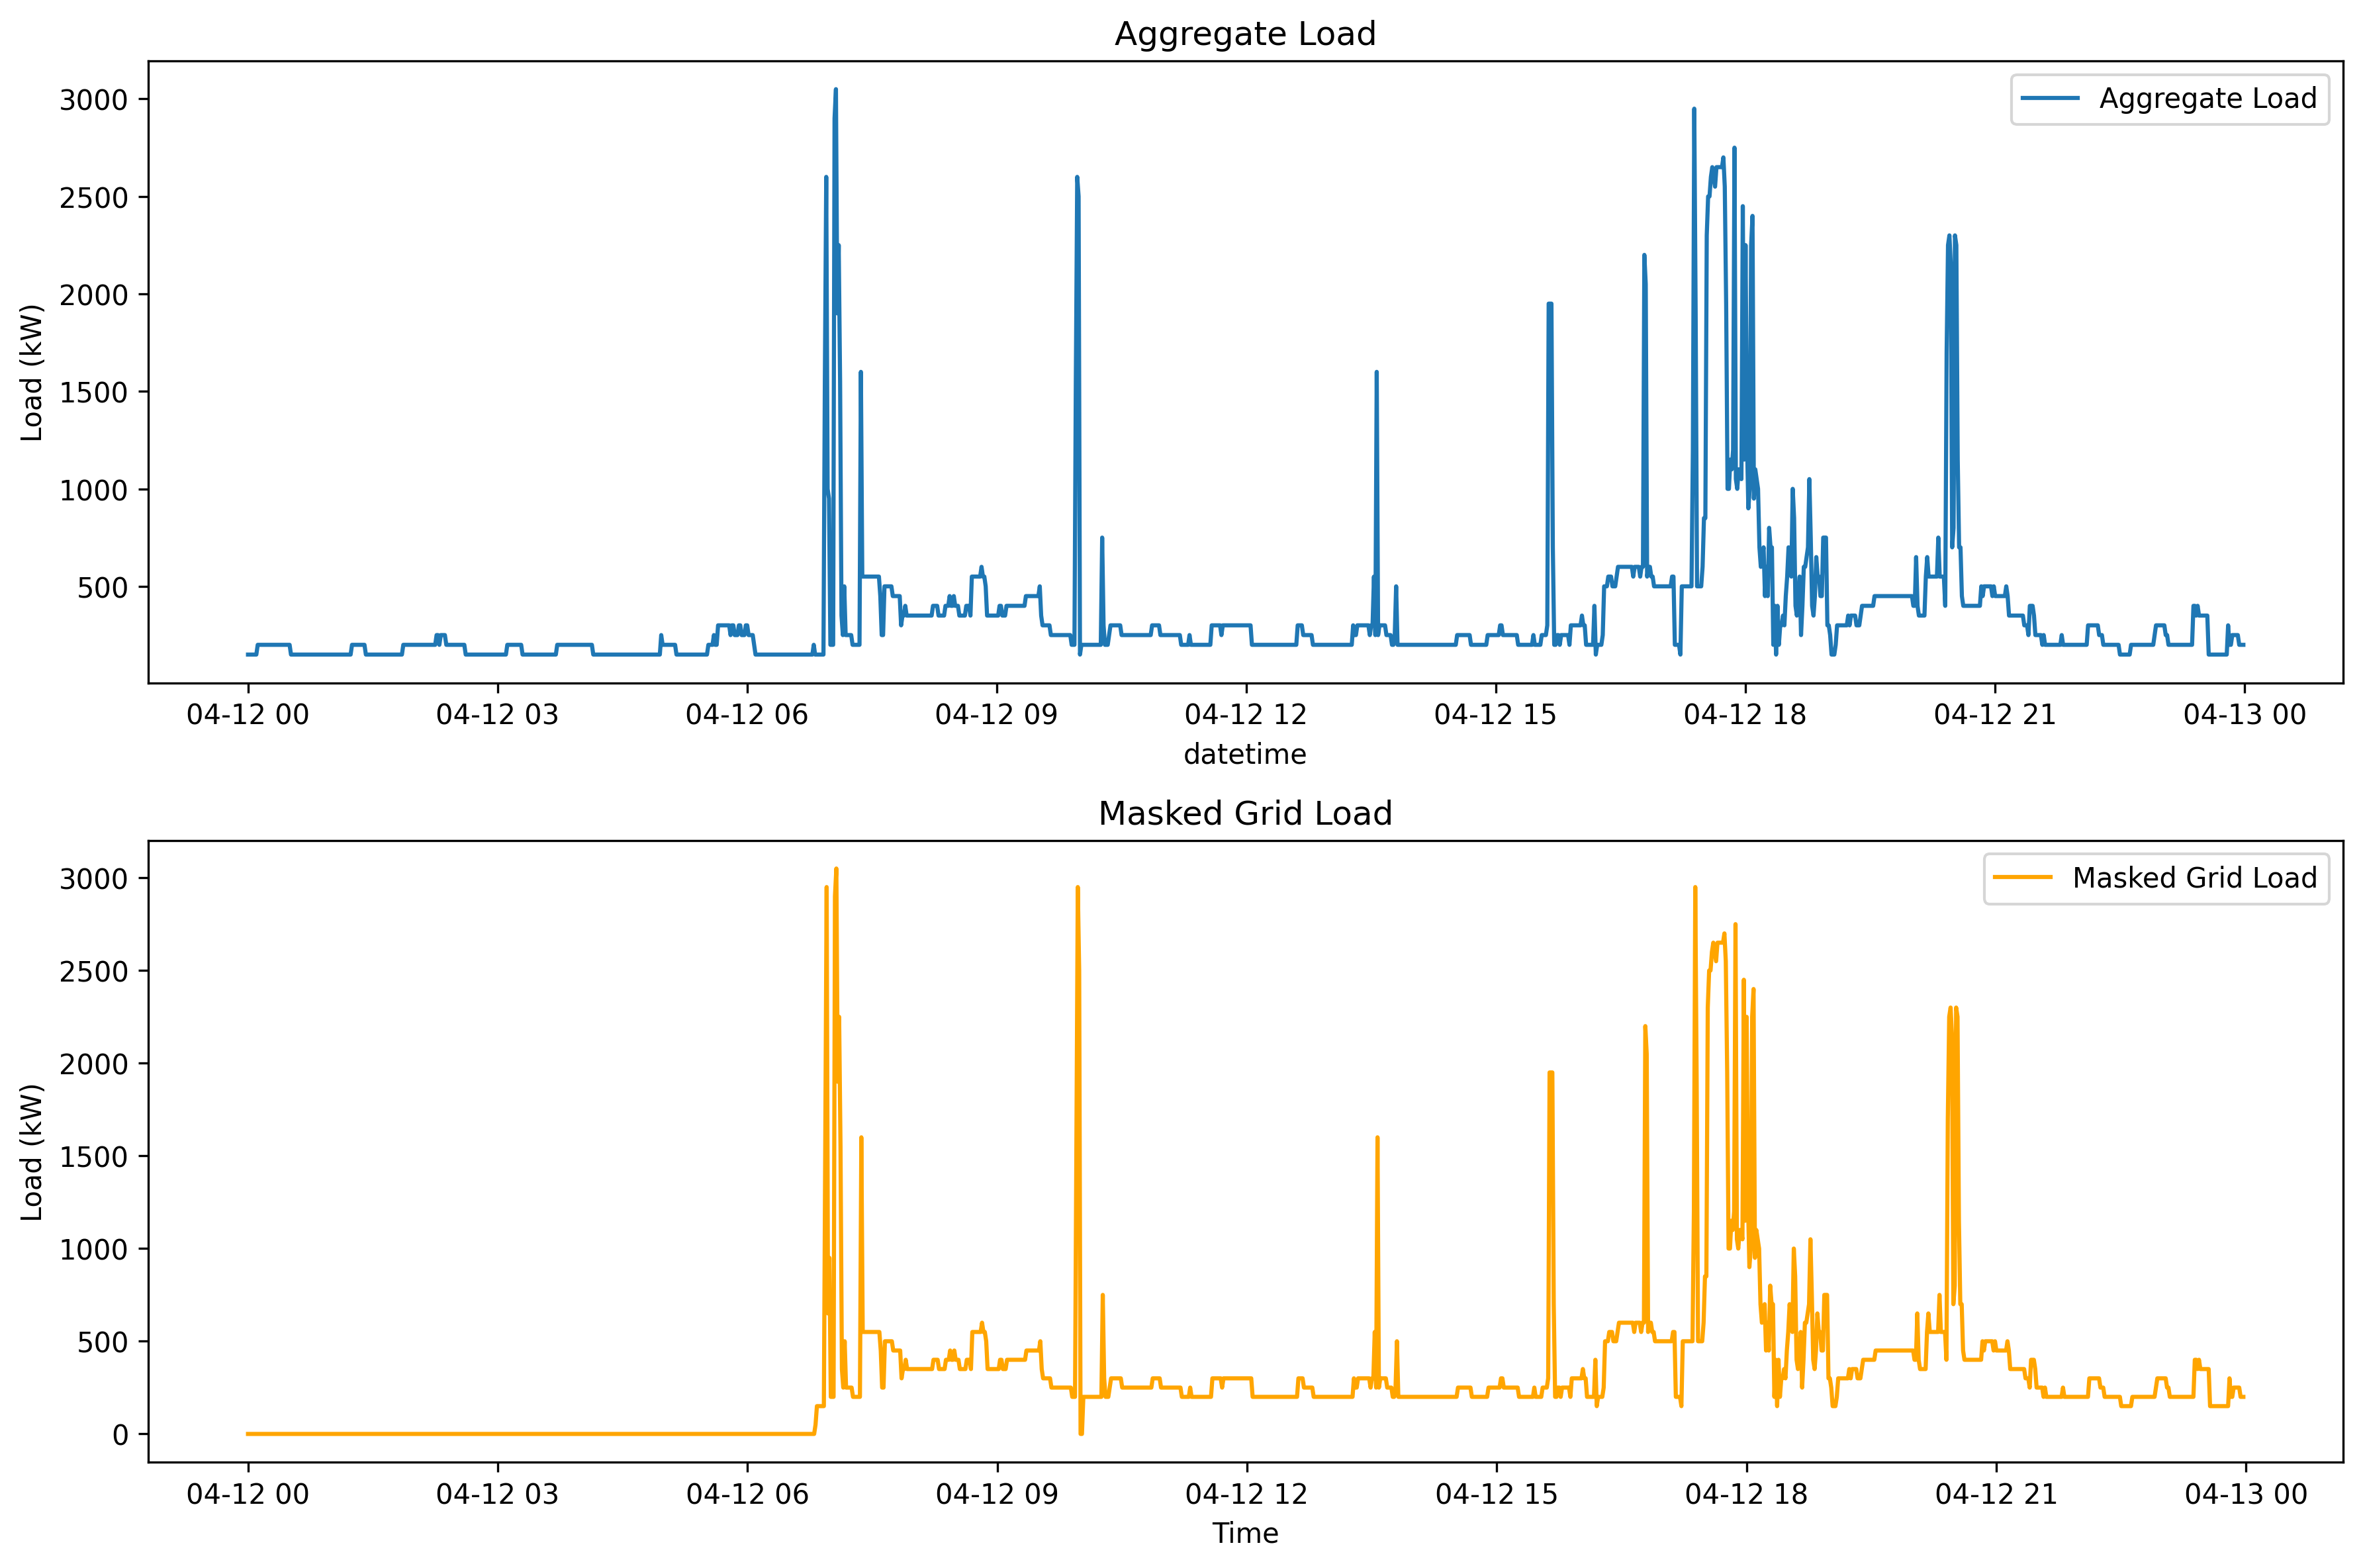

In [132]:
# create a plot with two subplots
# on top plot the aggregate load
# on bottom plot the masked grid load
# to better visualize the difference between the two

import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), dpi=300)
sns.lineplot(x=env_valid.episode.df['datetime'], y=env_valid.episode.df['aggregate'], ax=ax1, label='Aggregate Load')
sns.lineplot(x=env_valid.episode.df['datetime'], y=env_valid.episode.df['grid_load'], ax=ax2, label='Masked Grid Load', color='orange')

ax1.set_title('Aggregate Load')
ax1.set_ylabel('Load (kW)')
ax1.legend()
ax2.set_title('Masked Grid Load')
ax2.set_xlabel('Time')
ax2.set_ylabel('Load (kW)')
ax2.legend()
plt.tight_layout()
plt.show()

In [60]:
# save the graph

env_valid.save_graph(
    {"fname": str(experiment_folder / f"graph_valid_index_{env_valid.selected_idx}.png"),
     "dpi": 300}
)

In [55]:
env_valid.close()

[2025-07-18 03:31:54:177] [SmartMeterWorld] Environment closed.


---

In [ ]:
# load the model & environment
import sys
sys.path.append(str(Path('rl_env')))

from rl_env.base.env_module import SmartMeterEnvFactory
from stable_baselines3 import PPO
from model.H_network.h_network_arch import HNetworkType

# Create test data loader (if needed)
# sm_dl_test = SimpleSmartMeterDataLoader(
#     aggregate_load_segments=aggregate_load_segments_test,
#     aggregate_load_df=aggregate_load_df_test,
#     registry_path=experiment_folder / "simple_episode_registry_test.json"
# )

# env_test = SmartMeterEnvFactory.create(
#     action_type='discrete',
#     smart_meter_data_loader=sm_dl_test,
#     h_network_rl_module=h_network_rl_module,
#     mode=TrainingMode.TEST,
#     log_folder=experiment_folder / 'logs_test',
#     reward_lambda=REWARD_LAMBDA,
#     render_mode="human",
# )

# rl_model_path = Path("rl_model", "PPO", f"{datetime(2025,7,12,18,25,2).strftime('%Y%m%d_%H%M%S')}", "rl_model.zip")
# rl_model_loaded = PPO.load(rl_model_path, env=env_test)

In [ ]:
obs, info = env_test.reset(43)

In [ ]:
info

In [ ]:
env_test.reset_render_window()

In [ ]:
env_test.episode.df

In [ ]:
for i in range(1):
    done = False
    while not done:
        action, _states = rl_model_loaded.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env_test.step(action)
        print_log(f"Step: {env_test.episode.get_current_step()}, Action: {action}, Reward: {reward}, Info: {info}")
        env_test.render()

In [ ]:
env_test.save_graph(
    str(Path("rl_model", "PPO", f"{rl_datetime.strftime('%Y%m%d_%H%M%S')}", "graph_test.png"))
)

In [ ]:
env_test.close()